In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 100)
sns.set()

In [4]:
def load_test_train_data() :

    df_train = pd.read_csv("../data/raw/train.csv",index_col=0)
    df_test = pd.read_csv("../data/raw/test.csv", index_col=0)
    df_train["data_type"] = "train"
    df_test["data_type"] = "test"
    df_test["SalePrice"] = 0

    df = pd.concat([df_train, df_test], sort=False)
    df = df.reset_index(drop=True)

    print("Train Data Shape :", df_train.shape)
    print("Test Data Shape : ", df_test.shape)
    print("Combined Data Shape : ", df.shape)

    return (df_train, df_test, df)


In [5]:
train_df, test_df, full_df = load_test_train_data()

Train Data Shape : (1460, 81)
Test Data Shape :  (1459, 81)
Combined Data Shape :  (2919, 81)


In [8]:
def get_column_names_by_type(df):
    numeric_columns = df.describe().columns
    non_numeric_columns = [i for i in df.columns if i not in numeric_columns]
    return (numeric_columns, non_numeric_columns)
    

In [15]:
def impute_fields(df):
    
    df.Electrical = df.Electrical.fillna("SBrkr")

    """ Impute with equavelant of overall house quality : Average, equivalent "TA" """
    df.KitchenQual = df.KitchenQual.fillna("None")

    df.FireplaceQu = df.FireplaceQu.fillna("None")
    
    """ First change Garage Type for row with Null area and then change Garage Area """
    df.loc[df.GarageArea.isnull(), "GarageType"] = np.nan
    df.loc[df.GarageArea.isnull(), "GarageArea"] = 0
    
        

    """ For one record with Garage Area 360 and with missing Garage values, set to average values based on Overall Quality """
    df.loc[(df.GarageArea==360) & df.GarageFinish.isnull(), "GarageFinish"] = "Unf"
    df.loc[(df.GarageArea==360) & df.GarageQual.isnull(), "GarageQual"] = "TA"
    df.loc[(df.GarageArea==360) & df.GarageCond.isnull(), "GarageCond"] = "TA"
    """ Setting the Garage built to "Year Remodelled" """
    df.loc[(df.GarageArea==360) & df.GarageYrBlt.isnull(), "GarageYrBlt"] = df.YearRemodAdd


    
    """ Set rest of the missing Garage valies to None """
    df.GarageFinish = df.GarageFinish.fillna("None")
    df.GarageQual = df.GarageQual.fillna("None")
    df.GarageCond = df.GarageCond.fillna("None")
    df.GarageType = df.GarageType.fillna("None")

    df.GarageCars = df.GarageCars.fillna(0)


    
    """ Is it correct to fill with Zero for Year built as the scale will change compared to most values in 1900""" 
    df.GarageYrBlt = df.GarageYrBlt.fillna(0)


    """ Impiute with Typ as mentioned in documentation. There does not seem to be clear relation with
        Overall quality fields
    """
    df.loc[df.Functional.isnull(), "Functional"] = "Typ"


    """Basement Fullbath and Halfbath NA values are related to  houses without basements. Soe set them to 0 """
    df.BsmtFullBath = df.BsmtFullBath.fillna(0)
    df.BsmtHalfBath = df.BsmtHalfBath.fillna(0)
    
    return df

# Correct data values that seem incorrect

In [20]:
def correct_data(df):
    "Setting to the year remodeled"
    df.loc[df.GarageYrBlt==2207, "GarageYrBlt"] = 2007
    return df

# Transform Ordinal Categorical Columns

In [ ]:

def transform_ordinal(df):
    typical_graded_cols = ["HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond"]
    typical_grade_map = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}

    for i in typical_graded_cols:
        df[i].replace(typical_grade_map, inplace=True)
    
    df['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)
    df['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)
    
    return df

In [16]:
df = impute_fields(full_df)
df2 = df.iloc[:,38:64]

In [18]:
numeric_columns, categorical_columns = get_column_names_by_type(df2)


np.sum(df2[numeric_columns].isnull())

1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
GrLivArea       0
BsmtFullBath    0
BsmtHalfBath    0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64

In [201]:
df2.dtypes

Heating          object
HeatingQC         int64
CentralAir       object
Electrical       object
1stFlrSF          int64
2ndFlrSF          int64
LowQualFinSF      int64
GrLivArea         int64
BsmtFullBath    float64
BsmtHalfBath    float64
FullBath          int64
HalfBath          int64
BedroomAbvGr      int64
KitchenAbvGr      int64
KitchenQual       int64
TotRmsAbvGrd      int64
Functional        int64
Fireplaces        int64
FireplaceQu       int64
GarageType       object
GarageYrBlt     float64
GarageFinish      int64
GarageCars      float64
GarageArea      float64
GarageQual        int64
GarageCond        int64
dtype: object

# Skewness between test and train data

In [192]:
xx = df.groupby("data_type").agg(lambda x: len(x.unique()))

In [193]:
xx[numeric_columns][xx>15]

,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea
data_type,,,,,,,,,,,,,,,
test,789,407,NaN,879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,NaN,459.0
train,753,417,24.0,861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.0,NaN,441.0


# Skewness check for columns

In [194]:
numeric_columns

Index(['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea'],
      dtype='object')

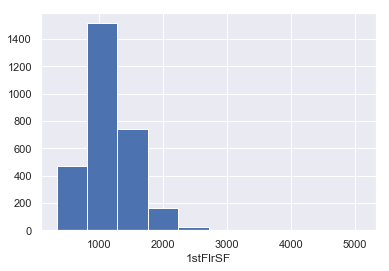

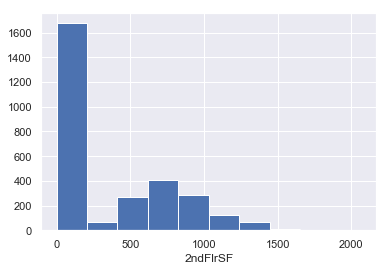

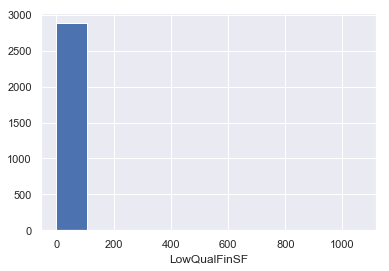

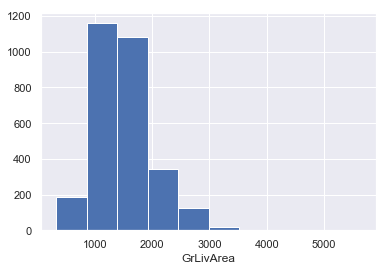

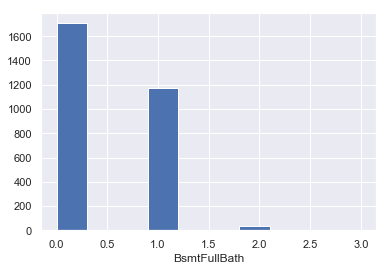

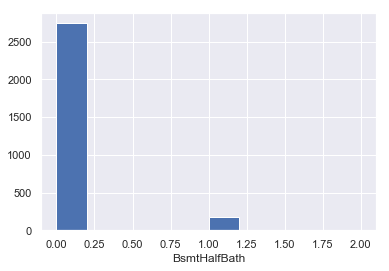

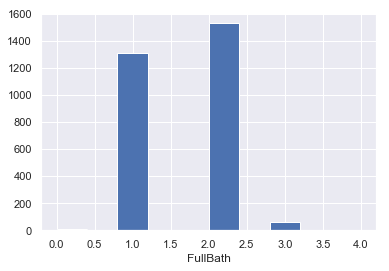

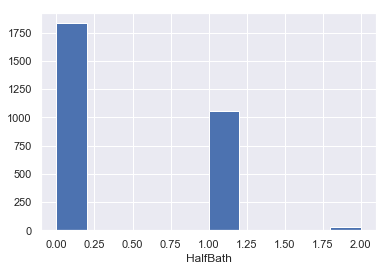

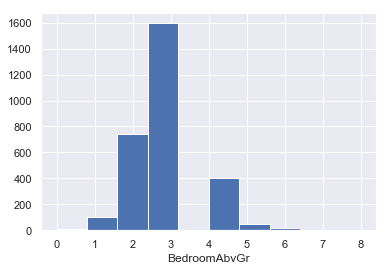

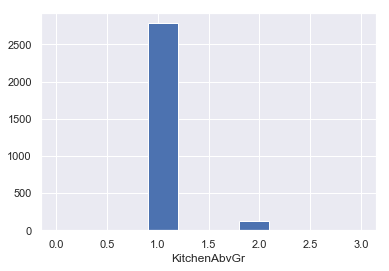

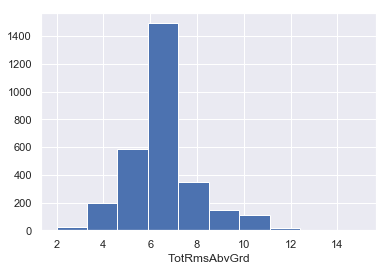

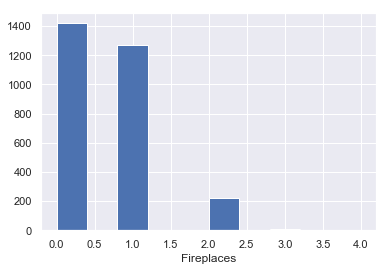

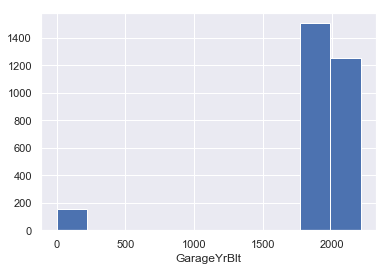

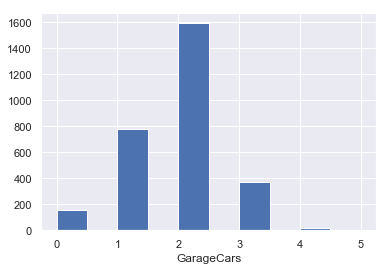

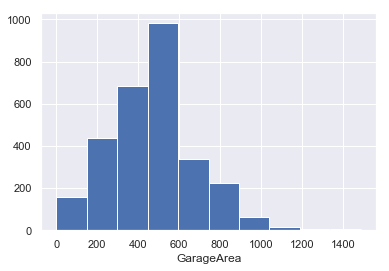

In [195]:
for i in numeric_columns:
    df[i].hist()
    plt.xlabel(i)
    plt.show()

In [196]:
from scipy.stats import skew
from scipy.stats import skewtest

skew(df["1stFlrSF"])

numeric_df = df[numeric_columns]

numeric_df.apply(skew).sort_values(ascending=False)



LowQualFinSF    12.088761
KitchenAbvGr     4.302254
BsmtHalfBath     3.931594
1stFlrSF         1.469604
GrLivArea        1.269358
2ndFlrSF         0.861675
TotRmsAbvGrd     0.758367
Fireplaces       0.733495
HalfBath         0.694566
BsmtFullBath     0.624832
BedroomAbvGr     0.326324
GarageArea       0.239257
FullBath         0.167606
GarageCars      -0.219581
GarageYrBlt     -3.920745
dtype: float64

In [197]:
skewtest(df["1stFlrSF"])

SkewtestResult(statistic=24.414601650729438, pvalue=1.196758793712818e-131)

# Extreme value check

In [215]:
df2.min()

Heating          Floor
HeatingQC            1
CentralAir           N
Electrical       FuseA
1stFlrSF           334
2ndFlrSF             0
LowQualFinSF         0
GrLivArea          334
BsmtFullBath         0
BsmtHalfBath         0
FullBath             0
HalfBath             0
BedroomAbvGr         0
KitchenAbvGr         0
KitchenQual          2
TotRmsAbvGrd         2
Functional           1
Fireplaces           0
FireplaceQu          0
GarageType      2Types
GarageYrBlt          0
GarageFinish         0
GarageCars           0
GarageArea           0
GarageQual           0
GarageCond           0
dtype: object

In [216]:
df2.max()

Heating          Wall
HeatingQC           5
CentralAir          Y
Electrical      SBrkr
1stFlrSF         5095
2ndFlrSF         2065
LowQualFinSF     1064
GrLivArea        5642
BsmtFullBath        3
BsmtHalfBath        2
FullBath            4
HalfBath            2
BedroomAbvGr        8
KitchenAbvGr        3
KitchenQual         5
TotRmsAbvGrd       15
Functional          7
Fireplaces          4
FireplaceQu         5
GarageType       None
GarageYrBlt      2207
GarageFinish        3
GarageCars          5
GarageArea       1488
GarageQual          5
GarageCond          5
dtype: object

In [219]:
""" 2207 for Garage built is odd value"""
df[df.GarageYrBlt==2207]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
2592,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,5,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,5,6,7,1,4,Attchd,2207.0,2,2.0,502.0,3,3,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,Partial,0,test


In [225]:

df = correct_data(df)
df2 = df.iloc[:,38:64]

In [226]:
""" Checking the extreme value of 15 for Total rooms"""
df[df.TotRmsAbvGrd == 15]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data_type
2549,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,5,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,5,15,7,2,4,Attchd,2008.0,3,3.0,1154.0,3,3,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,2007,New,Partial,0,test


In [228]:
""" Does not see totally odd, given other values abouve 10"""
df.TotRmsAbvGrd.value_counts()

6     844
7     649
5     583
8     347
4     196
9     143
10     80
11     32
3      25
12     16
15      1
13      1
14      1
2       1
Name: TotRmsAbvGrd, dtype: int64

# Dummy variable genaration
